# Spatial clustering of zebrafish 10hpf embryo stereo-seq data using STpipe

Compiled: April 5, 2024

For this tutorial, we will be analyzing the a dataset of zebrafish 10hpf embryos freely available from stomics. There are 19102 single cells that were sequenced on the 
DNBSEQ-T1. The Stereo-seq data is from https://db.cngb.org/stomics/datasets/STDS0000057. Click on the "Data" tab, where you can find Stereo-seq and scrna-seq data for zebrafish 10hpf embryos. Both datasets have been analyzed, but we can demonstrate using the raw counts for further analysis.

## Import the required packages

In [2]:
import anndata
import stpipe as sp
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
from collections import OrderedDict

## Import the zebrafish Stereo-seq data

In [3]:
adata=anndata.read_h5ad('zf10_stereoseq.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 19102 × 18698
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors'
    layers: 'counts'

In [5]:
adata.X=adata.layers['counts']

In [6]:
adata.obs['slice'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

## Filter

You can use SpatialQC(https://github.com/mgy520/SpatialQC) to generate a quality control report. Let's continue.

In [7]:
adata=sp.filter_cells(adata,min_genes=1)
adata=sp.filter_genes(adata,min_cells=1)

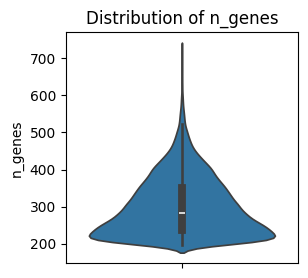

In [8]:
sp.violin(adata,feature='n_genes',fig_size=(3,3))

## Normalize

STpipe utilizes the global-scaling normalization method called "LogNormalize". This method normalizes the measured expression values of each feature in each cell by the total expression across all features, multiplying by a scaling factor (default is 10000), and then applying a logarithmic transformation to the result.

For scaling factor, you can refer to the maximum number of counts and try to avoid a gap of several orders of magnitude. This will affect subsequent differential expression gene analysis.

In [9]:
np.max(np.sum(adata.X, axis=1))

1983.0

In [10]:
adata=sp.lognormal(adata,scale_factor=2000)

## Find variable genes

STpipe uses the VST (Variance Stabilizing Transformation) algorithm to identify highly variable genes, similar to the Seurat in R.

In [11]:
adata=sp.vst_highly_variable_genes(adata,n_top_genes=2000)

In [12]:
adata

AnnData object with n_obs × n_vars = 19102 × 18698
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'n_genes'
    var: 'n_cells', 'highly_variable', 'variances_norm', 'means'
    layers: 'counts'

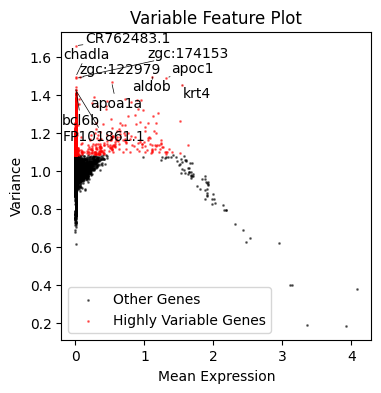

In [13]:
ranked_genes = np.argsort(adata.var['variances_norm'])[::-1]
top_genes = adata.var_names[ranked_genes[:10]]
sp.variable_plot(adata, log=False,figsize=(4,4),annotate_genes=top_genes)

## Scale

Next, we extract highly variable genes and then standardize the expression matrix to conform to a standard normal distribution with a mean of 0 and a variance of 1. This must be done before conducting PCA analysis.

In [14]:
adata.layers['logcounts'] = adata.X
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata=sp.scale(adata)

## PCA

Next we perform PCA on the scaled data. 

In [15]:
adata=sp.PCA(adata)

[pca] >A Python Package for Principal Component Analysis (https://github.com/erdogant/pca)
[pca] >Input data is a sparse matrix. Method is set to: [trunc_svd].
[pca] >The PCA reduction is performed on the [2000] columns of the input dataframe.
[pca] >Fit using Truncated SVD.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >done.


## Determine the PCs used for subsequent analysis.

The PCA variance selection Scree plot is a commonly used visualization tool to aid in determining how many principal components should be retained. This plot illustrates the proportion of variance explained by each principal component, typically showing a gradual decrease in variance explained proportion as the number of principal components increases. In the plot, a "bend point" or "knee" is often observed, indicating a sharp decline in the proportion of variance explained. This "knee point" is typically considered the appropriate position to select the number of principal components because it represents a significant change in the rate of decrease in explained variance proportion with the addition of more principal components. In the figure below, we select the first 15 PCs.

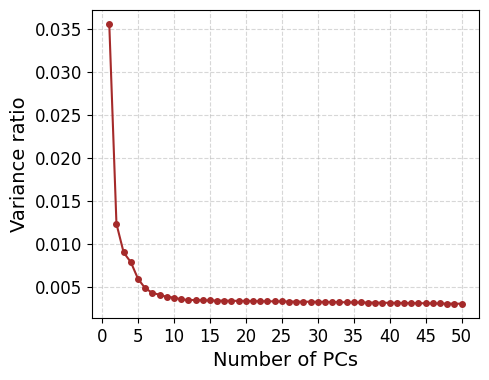

In [16]:
sp.pca_variance_ratio(adata,npc=50)

## Spatial cluster

STpipe utilizes SC-MEB for spatial clustering. SC-MEB constructs a two-layer hierarchical probabilistic model. The first layer defines the conditional probability of low-dimensional representations of gene expression (e.g., principal components), while the second layer describes the prior probability of hidden labels and implements an MRF prior to promote spatial smoothness. SC-MEB is capable of automatically selecting the number of clusters. For more details, refer to [here](https://academic.oup.com/bib/article/23/1/bbab466/6440124) .

Here, we use the example of the Slice 10.

In [17]:
adata_s10 = adata[adata.obs['slice']==10]

In [18]:
adata_s10.obsm['spatial']=adata_s10.obs[['spatial_x','spatial_y']].values

In [25]:
adata_s10=adata_s10.raw.to_adata()

In [27]:
adata_s10 = adata_s10[:, adata_s10.var.highly_variable]

In [34]:
adata_s10.obs['row']=adata_s10.obs['spatial_x']
adata_s10.obs['col']=adata_s10.obs['spatial_y']

In [36]:
adata_s10=sp.cluster(adata_s10,K_set=np.arange(6,12),n_PCs=15,neighborhood_size=50)

Starting parallel computing...diff Energy = 28.1336
diff Energy = 8.30834
diff Energy = 8.7
diff Energy = 4.5
diff Energy = 19.6685
diff Energy = 5.59957
diff Energy = 3.82729
diff Energy = 2.8
diff Energy = 5.31734
diff Energy = 7.6
diff Energy = 32.9528
diff Energy = 5.2
diff Energy = 2.23038
diff Energy = 8.28174
diff Energy = 7.90139
diff Energy = 1.5
diff Energy = 5.37488
diff Energy = 12.7513
ICM Converged at Iteration = 7
ICM Converged at Iteration = 4
ICM Converged at Iteration = 2
ICM Converged at Iteration = 3
diff Energy = 2.4
ICM Converged at Iteration = 2
diff Energy = 2.87103
diff Energy = 11.9392
diff Energy = 2.43979
ICM Converged at Iteration = 8
diff Energy = 11.1484
diff Energy = 25.3783
ICM Converged at Iteration = 3
diff Energy = 8
diff Energy = 6
diff Energy = 4.8
ICM Converged at Iteration = 2


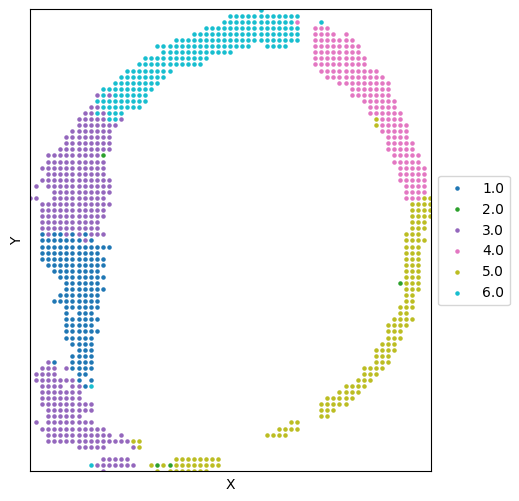

In [41]:
sp.plot_spatial(adata_s10,by='cluster',categorical=True,cmap='tab10',legend=True)